In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge  # For output layer training

class EchoStateNetwork:
    def __init__(self, n_reservoir=200, spectral_radius=0.9, input_scaling=1.0, leak_rate=0.3, ridge_alpha=1e-6):
        self.n_reservoir = n_reservoir
        self.spectral_radius = spectral_radius
        self.input_scaling = input_scaling
        self.leak_rate = leak_rate
        self.ridge_alpha = ridge_alpha
        self.W_in = None
        self.W_res = None
        self.W_out = None
        self.x = None  # Reservoir state

    def _initialize_weights(self, n_inputs=1):
        # Input weights: random, scaled
        self.W_in = np.random.uniform(-self.input_scaling, self.input_scaling, (self.n_reservoir, n_inputs))
        
        # Reservoir weights: random sparse, scaled to spectral radius
        self.W_res = np.random.uniform(-0.5, 0.5, (self.n_reservoir, self.n_reservoir))
        # Make sparse: keep 1% connections
        sparsity = 0.01
        n_connections = int(sparsity * self.n_reservoir**2)
        indices = np.random.choice(self.n_reservoir**2, n_connections, replace=False)
        self.W_res.flat[indices] = 0
        # Scale to spectral radius
        rho = np.max(np.abs(np.linalg.eigvals(self.W_res)))
        self.W_res /= rho / self.spectral_radius if rho != 0 else 1

    def _run_step(self, u):
        if self.x is None:
            self.x = np.zeros(self.n_reservoir)
        self.x = (1 - self.leak_rate) * self.x + self.leak_rate * np.tanh(np.dot(self.W_res, self.x) + np.dot(self.W_in, u))
        return self.x

    def fit(self, u, y):
        n_inputs = u.shape[1] if len(u.shape) > 1 else 1
        self._initialize_weights(n_inputs)
        
        # Collect reservoir states
        states = np.zeros((u.shape[0], self.n_reservoir))
        for t in range(u.shape[0]):
            states[t] = self._run_step(u[t])
        
        # Train output weights with Ridge regression (include bias)
        states_with_bias = np.hstack([np.ones((u.shape[0], 1)), states])
        self.W_out = Ridge(alpha=self.ridge_alpha).fit(states_with_bias, y).coef_  # 1D for single output

    def predict(self, u):
        predictions = []
        self.x = np.zeros(self.n_reservoir)  # Reset state
        for t in range(u.shape[0]):
            state = self._run_step(u[t])
            state_with_bias = np.hstack([1, state])
            pred = np.dot(self.W_out, state_with_bias)  # Scalar for single output
            predictions.append(pred)
        return np.array(predictions)

    def simulate(self, initial_seq, n_steps):
        """Autonomous simulation: Warm up with initial_seq, then feedback predictions"""
        predictions = []
        self.x = np.zeros(self.n_reservoir)  # Reset state
        
        # Warm-up: Drive with initial sequence
        for val in initial_seq:
            self._run_step(np.array([val]))
        
        # Autonomous steps: Feedback predicted value as next input
        current_input = initial_seq[-1] if len(initial_seq) > 0 else 0.0
        for _ in range(n_steps):
            state = self._run_step(np.array([current_input]))
            state_with_bias = np.hstack([1, state])
            pred = np.dot(self.W_out, state_with_bias)
            predictions.append(pred)
            current_input = pred  # Feedback
        return np.array(predictions)

In [2]:
# Chaotic map generators with optional noise (uniform noise ||η|| <= noise_intensity)
def doubling_map(x0, n_steps, r=2.0, noise_intensity=0.0):
    """Doubling map: x_{n+1} = r * x_n mod 1 + noise"""
    x = np.zeros(n_steps)
    x[0] = x0
    for i in range(1, n_steps):
        x[i] = (r * x[i-1]) % 1
        if noise_intensity > 0:
            x[i] += np.random.uniform(-noise_intensity, noise_intensity)
            x[i] = np.clip(x[i], 0, 1)  # Keep in [0,1]
    return x

def triplet_map(x0, n_steps, r=3.0, noise_intensity=0.0):
    """Triplet map: x_{n+1} = r * x_n mod 1 + noise"""
    x = np.zeros(n_steps)
    x[0] = x0
    for i in range(1, n_steps):
        x[i] = (r * x[i-1]) % 1
        if noise_intensity > 0:
            x[i] += np.random.uniform(-noise_intensity, noise_intensity)
            x[i] = np.clip(x[i], 0, 1)
    return x

def logistic_map(x0, n_steps, r=4.0, noise_intensity=0.0):
    """Logistic map: x_{n+1} = r * x_n * (1 - x_n) + noise"""
    x = np.zeros(n_steps)
    x[0] = x0
    for i in range(1, n_steps):
        x[i] = r * x[i-1] * (1 - x[i-1])
        if noise_intensity > 0:
            x[i] += np.random.uniform(-noise_intensity, noise_intensity)
            x[i] = np.clip(x[i], 0, 1)
    return x

def tent_map(x0, n_steps, r=2.0, noise_intensity=0.0):
    """Tent map: x_{n+1} = r * x_n if x_n < 0.5 else r*(1 - x_n) + noise"""
    x = np.zeros(n_steps)
    x[0] = x0
    for i in range(1, n_steps):
        if x[i-1] < 0.5:
            x[i] = r * x[i-1]
        else:
            x[i] = r * (1 - x[i-1])
        x[i] %= 1  # Mod 1
        if noise_intensity > 0:
            x[i] += np.random.uniform(-noise_intensity, noise_intensity)
            x[i] = np.clip(x[i], 0, 1)
    return x

def henon_map(x0, y0, n_steps, a=1.4, b=0.3, noise_intensity=0.0):
    """Henon map (2D): Returns x series only for 1D compatibility; noise added to x"""
    x = np.zeros(n_steps)
    y = np.zeros(n_steps)
    x[0] = x0
    y[0] = y0
    for i in range(1, n_steps):
        x_new = 1 - a * x[i-1]**2 + y[i-1]
        y[i] = b * x[i-1]
        x[i] = x_new
        if noise_intensity > 0:
            x[i] += np.random.uniform(-noise_intensity, noise_intensity)
    return x  # Return x component

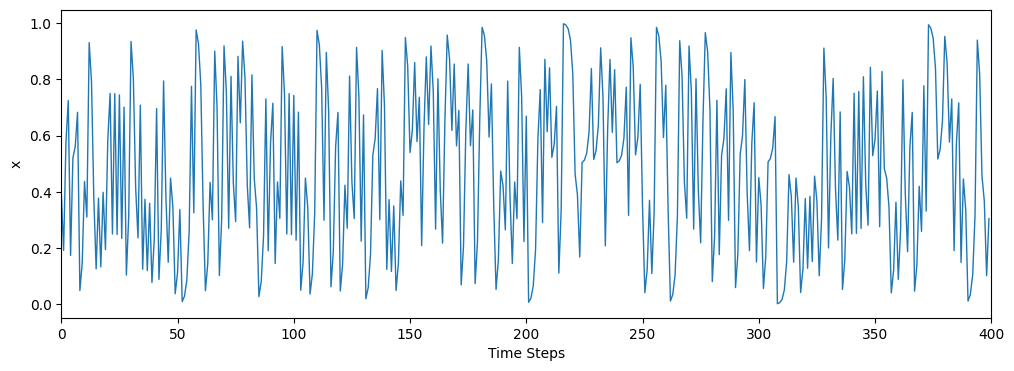

In [3]:
# Generate chaotic time series
n_steps = 500
transient = 100
x0 = 0.1
noise_intensity = 0.0  # Set to 0 for no noise
#series = henon_map(x0, 0.0, n_steps, noise_intensity=noise_intensity)
#series = doubling_map(x0, n_steps, noise_intensity=noise_intensity)
series = triplet_map(x0, n_steps, noise_intensity=noise_intensity)
#series = logistic_map(x0, n_steps, noise_intensity=noise_intensity)


# Post-transient data
X = series[transient:]

# Plot the time series
plt.figure(figsize=(12, 4))
plt.plot(X, linewidth=1)
plt.xlim([0, len(X)])
plt.xlabel('Time Steps')
plt.ylabel('x')
#plt.grid(False, alpha=0.3)
plt.show()

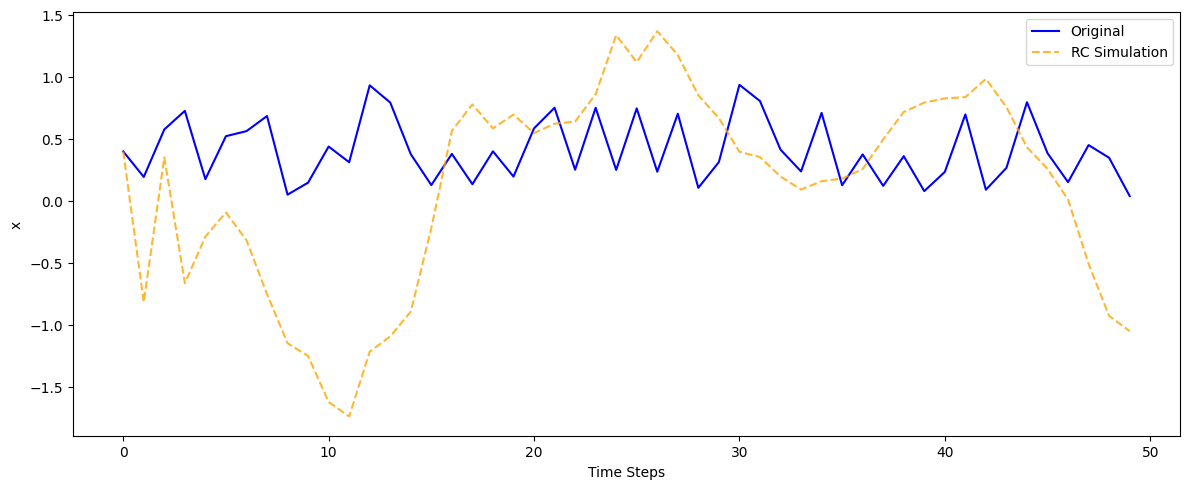

MSE: 0.791875


In [36]:
# Generate data with transient
n_steps = 200
transient = 100
x0 = 0.1
noise_intensity = 0.0  # Set to 0 for no noise
#series = henon_map(x0, 0.0, n_steps, noise_intensity=noise_intensity)
#series = doubling_map(x0, n_steps, noise_intensity=noise_intensity)
series = triplet_map(x0, n_steps, noise_intensity=noise_intensity)
#series = logistic_map(x0, n_steps, noise_intensity=noise_intensity)

# Post-transient data
X = series[transient:]

# Prepare training data: input u = x_t, target y = x_{t+1}
n_data = len(X)
train_u = X[:-1].reshape(-1, 1)
train_y = X[1:].reshape(-1, 1)

# Train ESN on all post-transient data
esn = EchoStateNetwork(n_reservoir=500, spectral_radius=13, leak_rate=.3, input_scaling=.8)
esn.fit(train_u, train_y)

# Simulation: Start from first 10 points of post-transient as initial sequence (warmup)
# Generate same length as post-transient (n_data points total, but warmup covers first 10, generate n_data - 10 more)
initial_seq = X[:1].flatten()
n_autonomous_steps = n_data - 1
reproduced_autonomous = esn.simulate(initial_seq, n_autonomous_steps)

# For comparison, the autonomous should start after warmup, so full autonomous sequence is initial_seq + reproduced_autonomous
full_autonomous = np.concatenate([initial_seq, reproduced_autonomous])

# Plot only first 150 time steps after transient (100-200 range, say 150 steps)
plot_steps = 50
t_plot = np.arange(plot_steps)

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(t_plot, X[:plot_steps], label='Original', color='blue')
ax.plot(t_plot, full_autonomous[:plot_steps], label='RC Simulation', color='orange', linestyle='--', alpha=0.8)
ax.set_xlabel('Time Steps')
ax.set_ylabel('x')
#ax.set_ylim([-0.1, 1.1])
ax.legend()
ax.grid(False)

plt.tight_layout()
plt.show()

# Compute MSE for subset (first 150 steps)
mse_autonomous_subset = np.mean((X[:plot_steps] - full_autonomous[:plot_steps])**2)
print(f'MSE: {mse_autonomous_subset:.6f}')